In [2]:
!pip install kaggle
!pip install pandas
!pip install sklearn
!pip install tensorflow
!pip install scikit-image
!pip install keras
!pip install seaborn 
!pip install matplotlib
!pip install opencv-python
!pip install medpy

     |████████████████████████████████| 58 kB 2.2 MB/s eta 0:00:011
     |████████████████████████████████| 76 kB 4.3 MB/s  eta 0:00:01
     |████████████████████████████████| 78 kB 6.8 MB/s  eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=b8462dd3dcf6c34b0c6dc22f5a37c88f2a43c95ec1b7bffdc5f4f83f5ecd8f47
  Stored in directory: /root/.cache/pip/wheels/77/47/e4/44a4ba1b7dfd53faaa35f59f1175e123b213ff401a8a56876b
Successfully built kaggle
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 9.5 MB 3.7 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 22.2 MB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 6.3 MB/s eta 0:00:01
     |████████████████████████████████| 306 kB 27.1 MB/s eta 0:00:01     |████████████████████████████▉   | 276 kB 2

In [3]:
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle
!ls /root/.kaggle

kaggle.json


In [4]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets list -s "AttentionLayer241"

ref                                                   title                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------  ----------------------------------  ----  -------------------  -------------  ---------  ---------------  
attentionlayer241/celeba-spoof-for-face-antispoofing  CelebA Spoof For Face AntiSpoofing  72GB  2021-05-31 15:05:19            274          6  0.375            
attentionlayer241/celeba-spoof-depth-image            CelebA Spoof Depth Image             6GB  2021-05-30 09:20:24              4          0  0.125            
attentionlayer241/celeba-spoof-reflection-images      CelebA Spoof Reflection Images       9GB  2021-05-30 18:18:28              0          0  0.125            
attentionlayer241/celeba-spoof-reflection-image       Celeba Spoof Reflection Image        9GB  2021-07-06 09:02:12              2          0  0.125            


In [7]:
!kaggle datasets download attentionlayer241/celeba-spoof-for-face-antispoofing

100%|█████████████████████████████████████▉| 71.9G/71.9G [30:06<00:00, 47.0MB/s]
100%|██████████████████████████████████████| 71.9G/71.9G [30:06<00:00, 42.8MB/s]


In [9]:
!unzip -q celeba-spoof-for-face-antispoofing.zip -d celeba-spoof-for-face-antispoofing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
os.listdir()

['.bashrc',
 '.profile',
 '.vast_containerlabel',
 'onstart.sh',
 'onstart.log',
 '.ssh',
 '.local',
 '.cache',
 'kaggle.json',
 'Celeba14k_ModelTraining_CNN.ipynb',
 '.ipynb_checkpoints',
 '.ipython',
 '.kaggle',
 'celeba-spoof-for-face-antispoofing.zip',
 'celeba-spoof-for-face-antispoofing',
 '.config']

In [14]:
import os
if os.path.exists("celeba-spoof-for-face-antispoofing.zip"):
    os.remove("celeba-spoof-for-face-antispoofing.zip")
else:
    print("The file does not exist") 

In [15]:
import shutil

total, used, free = shutil.disk_usage("/")

print("Total: %d GiB" % (total // (2**30)))
print("Used: %d GiB" % (used // (2**30)))
print("Free: %d GiB" % (free // (2**30)))

Total: 151 GiB
Used: 77 GiB
Free: 73 GiB


In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
# RUN apt-get update && apt-get install -y python3-opencv
# RUN pip install opencv-python
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io


from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from tensorflow.keras import backend as K
from tensorflow.keras import activations
from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import gc
from tensorflow.keras import callbacks
from sklearn.model_selection import KFold, StratifiedKFold

np.set_printoptions(suppress=True)


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [70]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

In [ ]:
# %cd /kaggle/working
# %cd ../input/celeba-spoof-for-face-antispoofing
# !pwd

In [17]:
def get_ratio_bbox_and_image(full_img_path, bound_box_path):
    img = cv2.imread(full_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    real_h, real_w, _ = img.shape
    area_image = real_h * real_w
    x1, y1, w1, h1 = get_area_bbox_indices(bound_box_path, real_w, real_h)
    area_bbox = w1*h1
    return area_bbox / area_image


def standard_width_height_scaling(real_w, real_h, bbox0, bbox1, bbox2, bbox3):
    x1 = int(int(bbox0)*(float(real_w) / 224)) # bbox[0]
    y1 = int(int(bbox1)*(float(real_h) / 224)) # bbox[1]
    w1 = int(int(bbox2)*(float(real_w) / 224)) # bbox[2]
    h1 = int(int(bbox3)*(float(real_h) / 224)) # bbox[3]
    return x1, y1, w1, h1


def get_area_bbox_indices(bound_box_path, real_w, real_h):
    bound_box_read = open(bound_box_path, "r")
    bound_box_indices = list()
    for i in bound_box_read:
        bound_box_indices.append(i)
    bbox = bound_box_indices[0].split()
    x1, y1, w1, h1 = standard_width_height_scaling(real_w, real_h, 
                                                   bbox[0], bbox[1], bbox[2], bbox[3])
    return x1, y1, w1, h1

def get_padding_bbox_indices(x1, y1, w1, h1, real_w, real_h, ratio_bbox_and_image):
    x1_padding = x1 - int((w1) * (1+ratio_bbox_and_image))
    y1_padding = y1 - int((h1) * (1+ratio_bbox_and_image))
    w1_padding = w1 + int((w1) * (1+ratio_bbox_and_image))
    h1_padding = h1 + int((h1) * (1+ratio_bbox_and_image))
    if x1_padding < 0: 
        x1_padding = 0
    if y1_padding < 0:
        y1_padding = 0
    if w1_padding > real_w:
        w1_padding = real_w
    if h1_padding > real_h:
        h1_padding = real_h
    return x1_padding, y1_padding, w1_padding, h1_padding
    
def read_crop_img_with_bbox(full_img_path, bound_box_path):
    img = cv2.imread(full_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     print(f"bound_box_path: {bound_box_path}")
#     print(f'bound box: {bbox}')
    real_w = img.shape[1]
    real_h = img.shape[0]
#     print(f'read_w = {img.shape[1]}')
#     print(f'read_h = {img.shape[0]}')
    x1, y1, w1, h1 = get_area_bbox_indices(bound_box_path, real_w, real_h)
#     print(f'x1={x1}, y1={y1}, w1={w1}, and h1={h1}')
    return x1, y1, w1, h1, img, real_w, real_h

In [19]:
from tqdm import tqdm
# Live Storage
original_cropped_storage = []
padding_cropped_storage = []
img_names = []
original_cropped_labels = []
padding_cropped_labels = []

count_live = 0
count_spoof = 0
dim = (160,160)
count_limit_live = 150000
count_limit_spoof = 150000

#rootdir_train = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/train'
rootdir_train = 'celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/train'
for file in tqdm(os.listdir(rootdir_train)):
#     file = '1'
    # file is 1, 1000, ..... 10029,...... => Name of folder 
    d = os.path.join(rootdir_train, file)
    if os.path.isdir(d):
        for e in tqdm(os.listdir(d)):
            # e is "live" of "spoof"
            imgs_path = d + '/' + e + '/'
#             print(imgs)
            for img_path in os.listdir(imgs_path):
#                 print(img_path)
#                 imgs_path = '000184.jpg'
                if (img_path.endswith(".jpg")):
                    full_img_path = imgs_path + img_path
#                     print('full_img_path: {full_img_path}')
                    bound_box_path = full_img_path[0:-4] + '_BB.txt'
#                     print(f'bound_box_path: {bound_box_path}')
                    x1, y1, w1, h1, img, real_w, real_h = read_crop_img_with_bbox(full_img_path, bound_box_path)
                    ratio_bbox_and_image = get_ratio_bbox_and_image(full_img_path, bound_box_path)
#                     print(f'ratio_bbox_and_image = {ratio_bbox_and_image}')
                    x1_padding, y1_padding, w1_padding, h1_padding = get_padding_bbox_indices(x1, y1, w1, h1, 
                                                                                              real_w, real_h,
                                                                                              ratio_bbox_and_image)
#                     print(x1_padding, y1_padding, w1_padding, h1_padding)
#                     plt.imshow(img[y1_padding:y1+h1_padding,
#                                    x1_padding:x1+w1_padding])
                    padding_img = img[y1_padding:y1+h1_padding, x1_padding:x1+w1_padding]
                    try:
                        if (e == 'live' and count_live >= count_limit_live) or (e == 'spoof' and count_spoof >= count_limit_spoof):
                            continue
                        resized_padding_img = cv2.resize(padding_img, dim, interpolation = cv2.INTER_AREA)
                        padding_cropped_storage.append(resized_padding_img)
                        if e == 'live':
                            count_live = count_live + 1
                            padding_cropped_labels.append(1)
                        elif e == 'spoof':
                            count_spoof = count_spoof + 1
                            padding_cropped_labels.append(0)
                    except:
                        continue
                        
#                     original_img = img[y1:y1+h1,x1:x1+w1]
#                     try: 
#                         resized_original_img= cv2.resize(original_img, dim, interpolation = cv2.INTER_AREA)
#                         original_cropped_storage.append(resized_original_img)
#                         if e == 'live':
#                             count_live = count_live + 1
#                             original_cropped_labels.append(1)
#                         elif e == 'spoof':
#                             count_spoof = count_spoof + 1
#                             original_cropped_labels.append(0)
#                     except:
#                         continue
                    img_names.append(img_path)

#                     plt.imshow(img)
#                     plt.imshow(img[y1:y1+h1,x1:x1+w1])
#                     print(f'count_live: {count_live}')
#                     print(f'count_spoof: {count_spoof}')
                    if (count_live == count_limit_live and e == 'live') or (count_spoof == count_limit_spoof and e == 'spoof'):
                        break
#                 if count_live == count_limit_live and count_spoof == count_limit_spoof:
#                     break
            if count_live >= count_limit_live and count_spoof >= count_limit_spoof:
                break
    if count_live >= count_limit_live and count_spoof >= count_limit_spoof:
        print("DONE Extracting ")
        break


100%|██████████| 1/1 [00:00<00:00, 39.27it/s]

100%|██████████| 1/1 [00:00<00:00, 176.17it/s]

100%|██████████| 1/1 [00:00<00:00, 39.35it/s]

100%|██████████| 1/1 [00:00<00:00, 162.18it/s]

100%|██████████| 1/1 [00:00<00:00, 12.62it/s]

100%|██████████| 1/1 [00:00<00:00, 24.88it/s]

100%|██████████| 1/1 [00:00<00:00, 13.99it/s]

100%|██████████| 1/1 [00:00<00:00, 20.75it/s]

100%|██████████| 1/1 [00:00<00:00, 119.25it/s]

100%|██████████| 1/1 [00:00<00:00, 19.58it/s]

100%|██████████| 1/1 [00:00<00:00, 77.43it/s]

100%|██████████| 2/2 [00:00<00:00, 24.34it/s]

100%|██████████| 1/1 [00:00<00:00, 137.66it/s]

100%|██████████| 1/1 [00:00<00:00, 32.28it/s]

100%|██████████| 1/1 [00:00<00:00, 17.20it/s]

100%|██████████| 1/1 [00:00<00:00, 13.84it/s]

 27%|██▋       | 2203/8192 [38:56<1:45:52,  1.06s/it]


IndexError: list index out of range

### Saving the data in the NPZ file

In [22]:
X = np.asarray(padding_cropped_storage)
y = np.asarray(padding_cropped_labels)

In [23]:
X.shape, y.shape

((134440, 160, 160, 3), (134440,))

In [35]:
y[50]

0

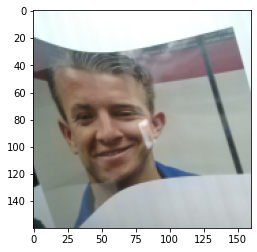

In [36]:
plt.imshow(X[50])

In [37]:
# Save the numpy to NUMPYZ 
X = np.asarray(padding_cropped_storage)
y = np.asarray(padding_cropped_labels)
np.savez('anti_spoofing_data.npz', X, y)
print("DONE SAVING DATA WITH NPZ")

DONE SAVING DATA WITH NPZ


### Checking the number of Live Samples and Spoof Samples after extracting 

In [ ]:
import pickle as pkl

with open('/content/testtttttttttttt/antispoofingInput40k.pkl', 'rb') as f:
  inp = pkl.load(f)
inp.shape

(40000, 124, 124, 3)

In [38]:
# anti_spoofing_data = np.load('/content/drive/MyDrive/livness detection/anti_spoofing_data_40k_124x_124.npz')
# X, y = anti_spoofing_data['arr_0'], anti_spoofing_data['arr_1']
temp = set(y)
check_live_label = 0
check_spoof_label = 0
for i in y: 
    if i == 1:
        check_live_label += 1
    elif i == 0:
        check_spoof_label += 1
print(f"There are 2 classes including number of live is {check_live_label} and number of spoof is {check_spoof_label}")

There are 2 classes including number of live is 46138 and number of spoof is 88302


In [ ]:
with open('target.pkl', 'wb') as target:
  pkl.dump(y, target)

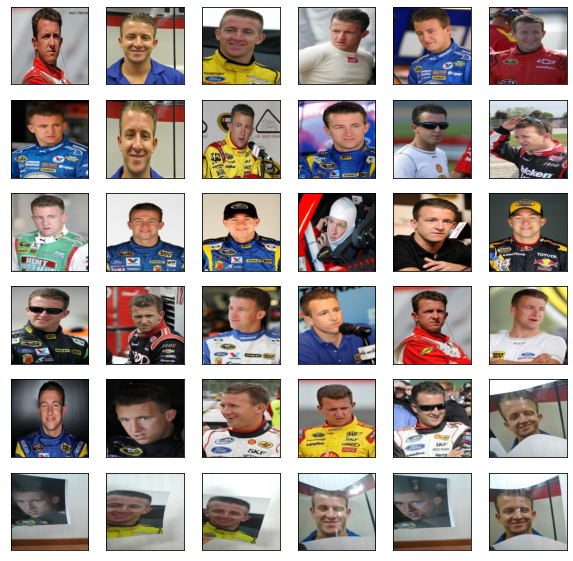

In [39]:
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
#     plt.imshow(original_cropped_storage[i])
    plt.imshow(X[i])
#     plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## SKlearn used for Splitting Training and Testing dataset

In [41]:
from sklearn.model_selection import train_test_split
import numpy as np

# X = np.asarray(padding_cropped_storage)
# y = np.asarray(padding_cropped_labels)
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
#X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)
print(f'Training dataset size of X_train: {len(X_train)}')
print(f'Testing dataset size of X_test: {len(X_test)}')
# print(f'Validation dataset size of X_valid: {len(X_valid)}')
print(f'Testing dataset size of y_train: {len(y_train)}')
print(f'Testing dataset size of y_test: {len(y_test)}')
# print(f'Testing dataset size of y_valid: {len(y_valid)}')

(134440, 160, 160, 3)
(134440,)
Training dataset size of X_train: 94108
Testing dataset size of X_test: 40332
Testing dataset size of y_train: 94108
Testing dataset size of y_test: 40332


In [ ]:
import pickle as pkl

with open('X.pkl','wb') as f:
  pkl.dump(X, f)

with open('y.pkl', 'wb') as target:
  pkl.dump(y, target)

In [ ]:
with open('X.pkl', 'rb') as f:
  X = pkl.load(f)
  print(X.shape)

(40000, 124, 124, 3)


## ===========================================================================================

## Read JSON file 

In [ ]:
# rootdir_train_json = '../input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/metas/intra_test/train_label.json'

# patients_df = pd.read_json(rootdir_train_json)
# patients_df.head()
# patients_df.iloc[:,0:19]

### Build a simple CNN Model for training, validating and testing

In [1]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Dropout,Input,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import model_from_json
import json

mobilenet = MobileNetV2(weights="imagenet",include_top=False,input_tensor=Input(shape=(160,160,3)))

/Users/nurmukhammed/opt/anaconda3/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/nurmukhammed/opt/anaconda3/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/nurmukhammed/opt/anaconda3/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/nurmukhammed/opt/anac

9412608/9406464 [==============================] - 1s 0us/step


In [2]:
mobilenet.trainable = False

In [3]:
output = Flatten()(mobilenet.output)
output = Dropout(0.3)(output)
output = Dense(units = 8,activation='relu')(output)
prediction = Dense(1,activation='sigmoid')(output)

In [4]:
model = Model(inputs = mobilenet.input,outputs = prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

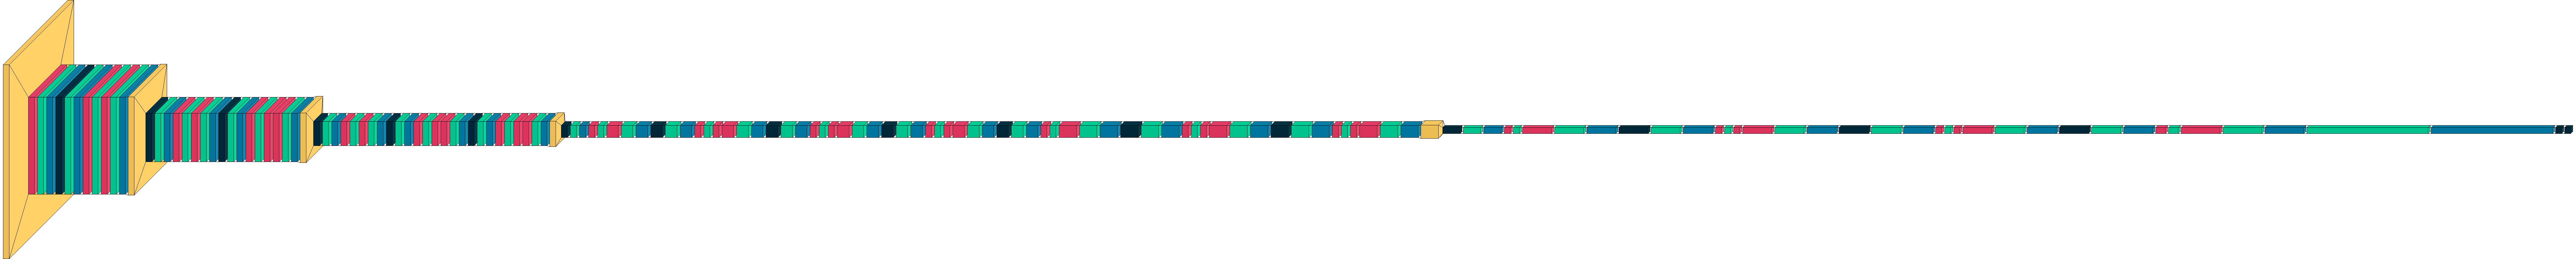

In [5]:
import visualkeras
visualkeras.layered_view(model)

In [51]:
from tensorflow.keras.callbacks import TensorBoard , ReduceLROnPlateau, EarlyStopping

In [52]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(
    learning_rate=0.000001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
),
  metrics=['accuracy']
)

In [48]:
import os
os.mkdir('/root/model_weights/')

In [53]:
model_checkpoint = ModelCheckpoint('./model_weights/finalyearproject_antispoofing_model_{epoch:02d}-{val_accuracy:.6f}.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True,save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [55]:
from sklearn.model_selection import KFold, StratifiedKFold
import gc
from tensorflow.keras import backend as K

# X_train, X_test, y_train, y_test
# history = model.fit(X_train, y_train, epochs=60, batch_size =16,
#                     validation_data=(X_valid, y_valid), callbacks = [checkpoint, es])


epochs=40
k = 3
kfold = KFold(n_splits=k, shuffle=True, random_state=42)
cvscores = []
historieskv = []
Fold = 1
for train, val in kfold.split(np.array(X_train), y_train):
    gc.collect()
    K.clear_session()
    
    x_train = np.array(X_train)[train]
    x_val = np.array(X_train)[val]
    
    Y_train = y_train[train]
    Y_val = y_train[val]
     
    print("=========================================")
    print("====== K Fold Validation step => %d/%d =======" % (Fold,k))
    print("=========================================")

    historykv=model.fit(x_train, Y_train, 
              validation_data=(x_val, Y_val),
              epochs=epochs,
              batch_size=32,
              callbacks=[model_checkpoint,es], verbose=1)
    historieskv.append(historykv)
    
    
    # evaluate the model
    scores = model.evaluate(x_val, Y_val, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    
    
    Fold = Fold +1

print("%s: %.2f%%" % ("Mean Accuracy of CV scores: ",np.mean(cvscores)))
print("%s: %.2f%%" % ("Standard Deviation of CV scores: +/-", np.std(cvscores)))

loss_test, acc_test = model.evaluate(X_test, y_test)

print ("\n\n================================\n\n")
print ("Loss on Test Set: {}".format(loss_test))
print ("Accuracy on Test Set: {0:.2f} %".format(acc_test * 100))
print ("\n\n================================\n\n")

====== K Fold Validation step => 1/3 =======
Epoch 1/40
1961/1961 [==============================] - 381s 193ms/step - loss: 0.6510 - accuracy: 0.7027 - val_loss: 0.4105 - val_accuracy: 0.8100

Epoch 00001: val_loss improved from inf to 0.41051, saving model to ./model_weights/finalyearproject_antispoofing_model_01-0.810041.h5
Epoch 2/40
1961/1961 [==============================] - 383s 195ms/step - loss: 0.4473 - accuracy: 0.7936 - val_loss: 0.3460 - val_accuracy: 0.8486

Epoch 00002: val_loss improved from 0.41051 to 0.34602, saving model to ./model_weights/finalyearproject_antispoofing_model_02-0.848581.h5
Epoch 3/40
1961/1961 [==============================] - 378s 193ms/step - loss: 0.3857 - accuracy: 0.8275 - val_loss: 0.3110 - val_accuracy: 0.8674

Epoch 00003: val_loss improved from 0.34602 to 0.31100, saving model to ./model_weights/finalyearproject_antispoofing_model_03-0.867389.h5
Epoch 4/40
1961/1961 [==============================] - 375s 191ms/step - loss: 0.3565 - accura

In [60]:
X_train.shape, X.shape, X_test.shape

((94108, 160, 160, 3), (134440, 160, 160, 3), (40332, 160, 160, 3))

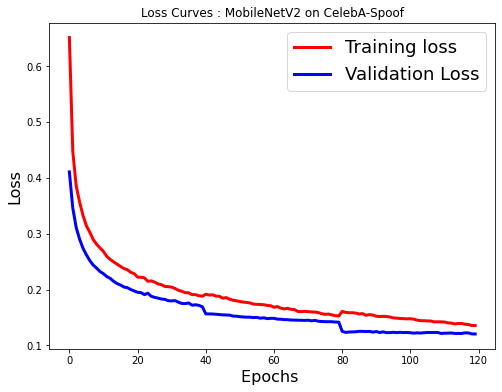

In [61]:
fig1 = plt.figure(figsize = (8,6))
plt.plot([j for i in historieskv for j in i.history['loss']],'r',linewidth=3.0)
plt.plot([j for i in historieskv for j in i.history['val_loss']],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title(f'Loss Curves : MobileNetV2 on CelebA-Spoof',fontsize=12)
plt.show()

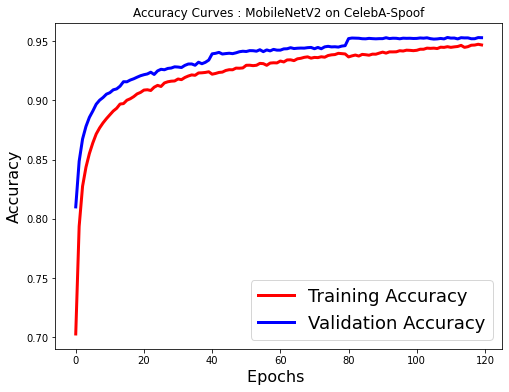

In [63]:
fig2=plt.figure(figsize = (8,6))
plt.plot([j for i in historieskv for j in i.history['accuracy']],'r',linewidth=3.0)
plt.plot([j for i in historieskv for j in i.history['val_accuracy']],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title(f'Accuracy Curves : MobileNetV2 on CelebA-Spoof',fontsize=12)
plt.show()

In [64]:
model_json = model.to_json()
with open('mobilenet_antispoofing_134kData.json', 'w') as json_file:
    json_file.write(model_json)


/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


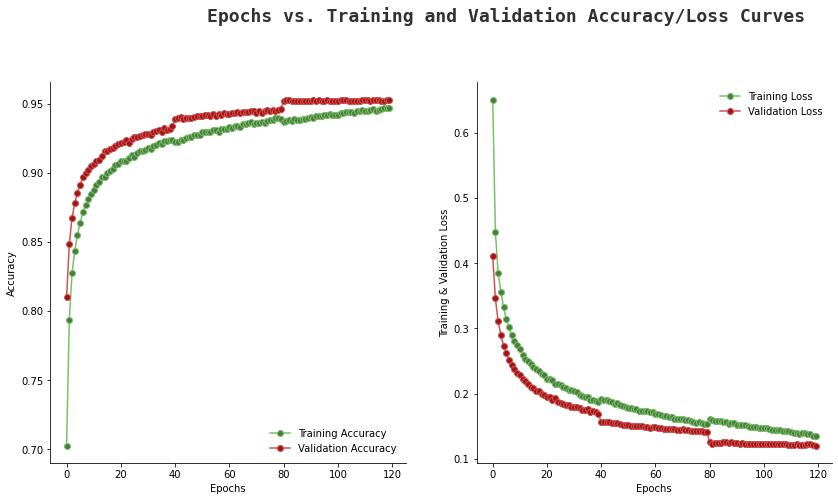

In [72]:
filterwarnings('ignore')

epochs = [i for i in range(120)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = [j for i in historieskv for j in i.history['accuracy']]
train_loss = [j for i in historieskv for j in i.history['loss']]
val_acc = [j for i in historieskv for j in i.history['val_accuracy']]
val_loss = [j for i in historieskv for j in i.history['val_loss']]

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss Curves',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=1)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.savefig('VGG16-Epochs vs. Training and Validation Accuracy|Loss Curves.png')
fig.show()

In [74]:
label_names= ['Spoof', 'Live']

In [95]:
y_pred = model.predict(X_test)
print(y_test[:10])
print(y_pred[:10])
print(y_test.shape, y_pred.shape)

[1 1 0 0 0 1 0 0 0 0]
[[0.0407677 ]
 [0.8348736 ]
 [0.02531654]
 [0.01354697]
 [0.02768153]
 [0.9999937 ]
 [0.000128  ]
 [0.07742184]
 [0.00354138]
 [0.00377905]]
(40332,) (40332, 1)


In [96]:
y_pred

array([[0.0407677 ],
       [0.8348736 ],
       [0.02531654],
       ...,
       [0.9987508 ],
       [0.22386521],
       [0.00095272]], dtype=float32)

In [97]:
y_pred_new = np.array([1 if i[0]>0.5 else 0 for i in y_pred])
print(y_test[:10])
print(y_pred_new[:10])
print(y_test.shape, y_pred_new.shape)

[1 1 0 0 0 1 0 0 0 0]
[0 1 0 0 0 1 0 0 0 0]
(40332,) (40332,)


In [98]:
print(classification_report(y_test,y_pred_new))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     26537
           1       0.94      0.91      0.92     13795

    accuracy                           0.95     40332
   macro avg       0.94      0.94      0.94     40332
weighted avg       0.95      0.95      0.95     40332



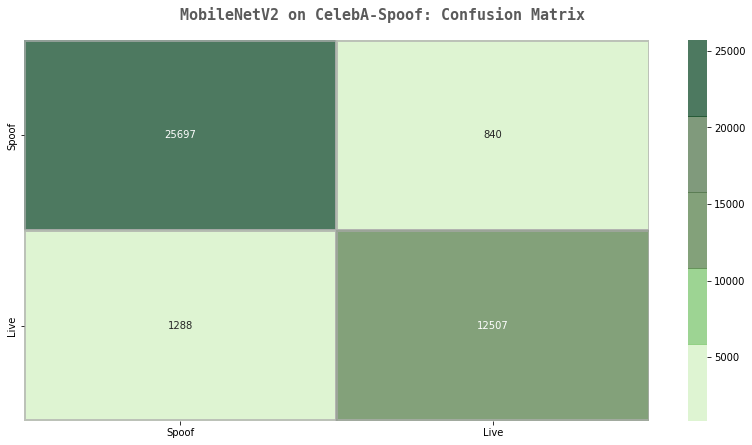

In [99]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test,y_pred_new),ax=ax,xticklabels=label_names,yticklabels=label_names,annot=True,fmt='g',
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='MobileNetV2 on CelebA-Spoof: Confusion Matrix',size=15,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [104]:
from sklearn.metrics import matthews_corrcoef
def overall_result(y_, y_predicted):
# save confusion matrix and slice into four pieces

    cnf_matrix = confusion_matrix(y_, y_predicted)
    TP = cnf_matrix[1][1]
    TN = cnf_matrix[0][0]
    FP = cnf_matrix[0][1]
    FN = cnf_matrix[1][0]

    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))

    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy

    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))

    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))

    result_s = {}
    result_s['Accuracy']           = [round(conf_accuracy,2)]
    result_s['Mis-Classification'] = [round(conf_misclassification,2)]
    result_s['Sensitivity']        = [round(conf_sensitivity,2)]
    result_s['Specificity']        = [round(conf_specificity,2)]
    result_s['Precision']          = [round(conf_precision,2)]
    result_s['F1 Score']           = [round(conf_f1,2)]
    result_s['MCC']                = [round(matthews_corrcoef(y_, y_predicted),2)]


    df_result           = pd.DataFrame(result_s)
    
    return df_result

In [105]:
overall_result(y_test, y_pred_new)

,Accuracy,Mis-Classification,Sensitivity,Specificity,Precision,F1 Score,MCC
0,0.95,0.05,0.91,0.97,0.97,0.94,0.88


In [120]:
y_test = np.argmax(y_test, axis=1)

In [127]:
from tensorflow.keras.utils import to_categorical
y_test_dummy = to_categorical(y_test)
y_pred_dummy = to_categorical(y_pred_new)

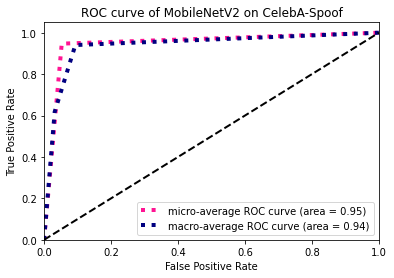

In [129]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as m
n_classes=2
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummy[:, i], y_pred_dummy[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_dummy.ravel(), y_pred_dummy.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of MobileNetV2 on CelebA-Spoof')
plt.legend(loc="lower right")
plt.show()